In [1]:

from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/datos_procesados.zip -d /content

Streaming output truncated to the last 5000 lines.
 extracting: /content/images/00021968_001.png  
 extracting: /content/images/00016486_011.png  
 extracting: /content/images/00029813_037.png  
 extracting: /content/images/00002437_003_aug_174.png  
 extracting: /content/images/00028300_007.png  
 extracting: /content/images/00022106_006.png  
 extracting: /content/images/00010475_050.png  
 extracting: /content/images/00000034_000.png  
 extracting: /content/images/00029655_000.png  
 extracting: /content/images/00016420_000.png  
 extracting: /content/images/00000398_003.png  
 extracting: /content/images/00028702_000.png  
 extracting: /content/images/00028674_000.png  
 extracting: /content/images/00003292_007.png  
 extracting: /content/images/00014751_001.png  
 extracting: /content/images/00007932_005.png  
 extracting: /content/images/00023794_000.png  
 extracting: /content/images/00014370_000.png  
 extracting: /content/images/00004468_001.png  
 extracting: /content/images/

In [2]:
# Import necessary packages
import keras
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import sklearn
import shap
import os
import seaborn as sns
import time
import pickle


In [3]:
train_df = pd.read_csv('/content/train_df.csv')
val_df = pd.read_csv('/content/val_df.csv')
test_df = pd.read_csv('/content/test_df.csv')
print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")


Train shape: (58045, 16)
Validation shape: (17063, 16)
Test shape: (16491, 16)


### Analisis de una imagen

Las dimensiones de la imagen son 320  píxeles de ancho y 320 píxeles de alto,con un solo canal de color


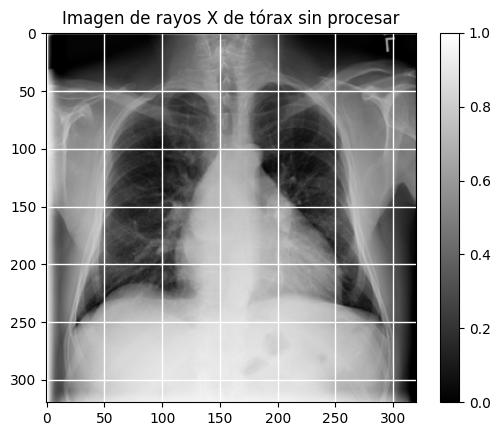

In [ ]:
sample_img = train_df.Image_file[0]
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.colorbar()
plt.title('Imagen de rayos X de tórax sin procesar')
print(f"Las dimensiones de la imagen son {raw_image.shape[0]}  píxeles de ancho y {raw_image.shape[1]} píxeles de alto,con un solo canal de color")

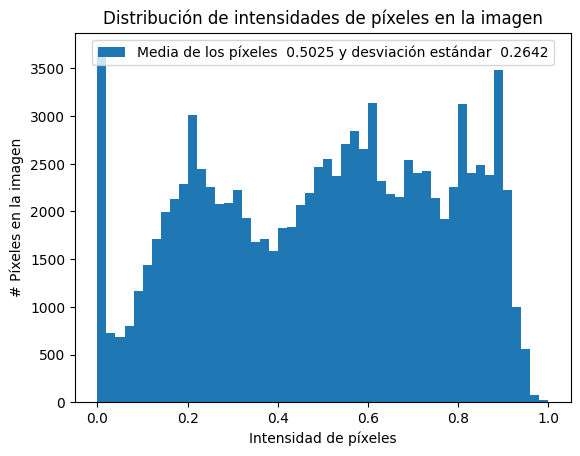

In [ ]:
pixels = np.reshape(raw_image,raw_image.shape[0]*raw_image.shape[1])
plt.hist(pixels, bins=50, label=f'Media de los píxeles  {np.mean(raw_image):.4f} y desviación estándar  {np.std(raw_image):.4f}')
plt.legend(loc='upper center')
plt.title('Distribución de intensidades de píxeles en la imagen')
plt.xlabel('Intensidad de píxeles')
plt.ylabel('# Píxeles en la imagen')
plt.show()

# Preprocesamiento de imágenes en Keras
### Estandarización

La normalización de imágenes es una de las más adecuadas para entrenar una red neuronal convolucional. Para esta tarea utilizamos la función ImageDataGenerator de Keras para realizar el preprocesamiento y el aumento de datos.

El `image_generator` ajustará los datos de la imagen de modo que la nueva media de los datos sea cero y la desviación estándar de los datos sea 1.  

En otras palabras, el generador reemplazará cada valor de píxel en la imagen con un nuevo valor calculado restando la media y dividiéndolo por la desviación estándar.

$$\frac{x_i - \mu}{\sigma}$$

Se creo un generador de imágenes para el preprocesamiento.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.

    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """
    # Normalize images  --- Generate batches of tensor image data with real-time data augmentation
    image_generator = ImageDataGenerator(
        samplewise_center=True,              #Set each sample mean to 0
        samplewise_std_normalization= True)  # Divide each input by its standard deviation

    print("\Generador de datos de entrenamiento...")
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",       #  Mode for yielding the targets, one of "binary", "categorical", "input", "multi_output", "raw", sparse" or None. Default: "categorical".
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))

    return generator

In [7]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8,
                                 seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.

    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    # get generator to sample dataset
    print(f"\nextracting {sample_size} train images to normalize validation and test datasets...")

    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=IMAGE_DIR,
        x_col=x_col,
        y_col=labels,
        class_mode="raw",
        batch_size=sample_size,
        shuffle=True,
        target_size=(target_w, target_h))

    # get data sample
    batch = raw_train_generator.__next__() # generate a batch of samples and associated labels
    data_sample = batch[0]             # => we need only the sample imgs ie batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)

    # fit generator to sample from training data - we use this generator normalizing mean and std using the train sample of 100
    image_generator.fit(data_sample)

    print("\Generador de datos de validación...")

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    print("\Generador de datos de testeo...")

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [8]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']
IMAGE_DIR = "images"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image_file", labels)
valid_generator, test_generator= get_test_and_valid_generator(val_df, test_df, train_df, IMAGE_DIR, "Image_file", labels)

\Generador de datos de entrenamiento...
Found 58045 validated image filenames.

extracting 100 train images to normalize validation and test datasets...
Found 58045 validated image filenames.
\Generador de datos de validación...
Found 17063 validated image filenames.
\Generador de datos de testeo...
Found 16491 validated image filenames.


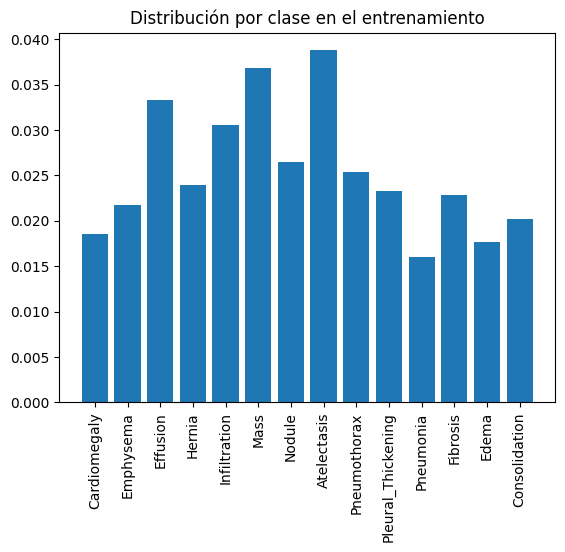

In [ ]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Distribución por clase en el entrenamiento")
plt.show()

Las dimensiones de la imagen son 320  píxeles de ancho y 320 píxeles de alto
El valor máximo de píxeles es 2.2033 y el mínimo es -2.2902


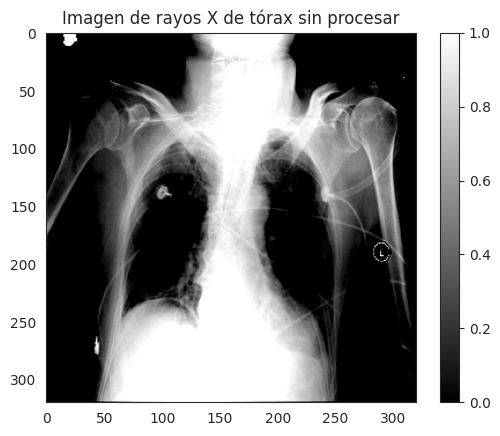

In [ ]:
# Plot a processed image
sns.set_style("white")
generated_image, label = train_generator.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Imagen de rayos X de tórax sin procesar')
print(f"Las dimensiones de la imagen son {generated_image.shape[1]}  píxeles de ancho y {generated_image.shape[2]} píxeles de alto")
print(f"El valor máximo de píxeles es {generated_image.max():.4f} y el mínimo es {generated_image.min():.4f}")

<ipython-input-15-8fb6d0546a56>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(raw_image.ravel(),
<ipython-input-15-8fb6d0546a56>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(generated_image[0].ravel(),


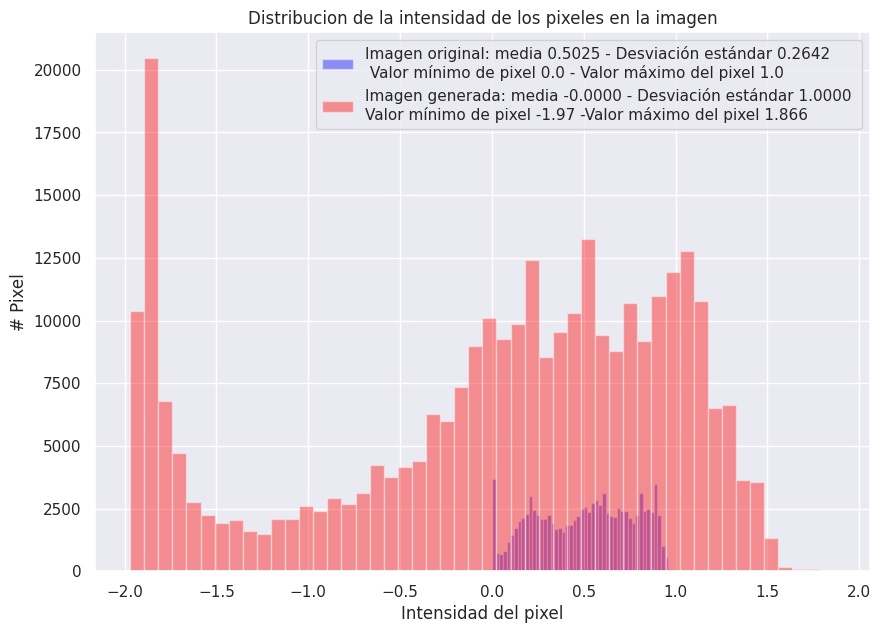

In [ ]:
# Include a histogram of the distribution of the pixels
sns.set()
plt.figure(figsize=(10, 7))

# Plot histogram for original iamge
sns.distplot(raw_image.ravel(),
             label=f'Imagen original: media {np.mean(raw_image):.4f} - Desviación estándar {np.std(raw_image):.4f} \n '
             f'Valor mínimo de pixel {np.min(raw_image):.4} - Valor máximo del pixel {np.max(raw_image):.4}',
             color='blue',
             kde=False)

# Plot histogram for generated image
sns.distplot(generated_image[0].ravel(),
             label=f'Imagen generada: media {np.mean(generated_image[0]):.4f} - Desviación estándar {np.std(generated_image[0]):.4f} \n'
             f'Valor mínimo de pixel {np.min(generated_image[0]):.4} -Valor máximo del pixel {np.max(generated_image[0]):.4}',
             color='red',
             kde=False)

# Place legends
plt.legend()
plt.title('Distribucion de la intensidad de los pixeles en la imagen')
plt.xlabel('Intensidad del pixel')
plt.ylabel('# Pixel')
plt.show()

# Mobilenet v2

In [9]:

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import roc_auc_score
import tensorflow as tf
# Define the model with transfer learning
def get_model_pretrained(num_classes, weights='imagenet', trainable=True):
    base_model = MobileNetV2(weights=weights, include_top=False, input_shape=(320, 320, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    if trainable:
      for layer in base_model.layers:
        layer.trainable = True
    else:
        for layer in base_model.layers:
           layer.trainable = False

    return model

# Define the model without transfer learning and without pretrained weights
def get_model_no_transfer_no_pretrained(num_classes):
    base_model = MobileNetV2(weights=None, include_top=False, input_shape=(320, 320, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Define the model from scratch
def get_model_from_scratch(num_classes):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(320,320,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
  ])
  return model

# Compile and train the model
def compile_and_train_model(model, train_generator, valid_generator, epochs=10, learning_rate=0.0001):
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])

    # Reduce learning rate when a metric has stopped improving.
    lr_reducer = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, monitor='val_auc', verbose=1)
    # Save the model after every epoch.
    checkpoint = ModelCheckpoint(filepath='best_weights.keras', save_best_only=True, monitor='val_auc', verbose=1)

    history = model.fit(
      x=train_generator,
      validation_data=valid_generator,
      epochs=epochs,
      callbacks=[lr_reducer, checkpoint]
    )
    return history, model

def evaluate_model(model, test_generator):
  # Evaluate
  y_true = test_generator.labels
  y_pred = model.predict(test_generator, verbose=1)
  roc_auc = roc_auc_score(y_true, y_pred)
  print(f'ROC AUC: {roc_auc:.4f}')

  return roc_auc


num_classes = len(labels)
epochs = 5
learning_rate = 0.0001






In [16]:
print("Entrenando red con transfer learning...")
model_transfer_learning = get_model_pretrained(num_classes)
history_transfer_learning, model_transfer_learning = compile_and_train_model(model_transfer_learning, train_generator, valid_generator, epochs, learning_rate)
roc_auc_transfer_learning = evaluate_model(model_transfer_learning, test_generator)


Entrenando red con transfer learning...


<ipython-input-9-5ebf0cdc1d5b>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights=weights, include_top=False, input_shape=(320, 320, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 667s 84ms/step - AUC: 0.7263 - loss: 0.1133 - val_AUC: 0.7854 - val_loss: 0.1924 - learning_rate: 1.0000e-04
Epoch 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_auc` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


7256/7256 ━━━━━━━━━━━━━━━━━━━━ 652s 84ms/step - AUC: 0.8165 - loss: 0.0976 - val_AUC: 0.7942 - val_loss: 0.1886 - learning_rate: 1.0000e-04
Epoch 3/5
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 564s 78ms/step - AUC: 0.8435 - loss: 0.0930 - val_AUC: 0.8052 - val_loss: 0.1866 - learning_rate: 1.0000e-04
Epoch 4/5
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 566s 78ms/step - AUC: 0.8669 - loss: 0.0894 - val_AUC: 0.8048 - val_loss: 0.2041 - learning_rate: 1.0000e-04
Epoch 5/5
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 567s 78ms/step - AUC: 0.8858 - loss: 0.0841 - val_AUC: 0.8062 - val_loss: 0.1769 - learning_rate: 1.0000e-04
2062/2062 ━━━━━━━━━━━━━━━━━━━━ 112s 52ms/step
ROC AUC: 0.7962


In [17]:
model_transfer_learning.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 320, 320, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 160, 160, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 160, 160, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 160, 160, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 160, 160, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 160, 160, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 160, 160, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 160, 160, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 160, 160, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 160, 160, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 160, 160, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 160, 160, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 161, 161, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 80, 80, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 10,684,012 (40.76 MB)

 Trainable params: 3,549,966 (13.54 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 7,099,934 (27.08 MB)

In [10]:

print("Entrenando red sin los pesos de su preentrenamiento...")
model_no_transfer_no_pretrained = get_model_no_transfer_no_pretrained(num_classes)
history_no_transfer_no_pretrained, model_no_transfer_no_pretrained = compile_and_train_model(model_no_transfer_no_pretrained, train_generator, valid_generator, epochs, learning_rate)
roc_auc_no_transfer_no_pretrained = evaluate_model(model_no_transfer_no_pretrained, test_generator)


Entrenando red sin los pesos de su preentrenamiento...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7256/7256 ━━━━━━━━━━━━━━━━━━━━ 699s 89ms/step - AUC: 0.6458 - loss: 0.1191 - val_AUC: 0.6556 - val_loss: 0.2002 - learning_rate: 1.0000e-04
Epoch 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_auc` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


7256/7256 ━━━━━━━━━━━━━━━━━━━━ 589s 81ms/step - AUC: 0.7059 - loss: 0.1098 - val_AUC: 0.7118 - val_loss: 0.2076 - learning_rate: 1.0000e-04
Epoch 3/5
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 586s 81ms/step - AUC: 0.7349 - loss: 0.1082 - val_AUC: 0.7066 - val_loss: 0.2055 - learning_rate: 1.0000e-04
Epoch 4/5
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 583s 80ms/step - AUC: 0.7470 - loss: 0.1069 - val_AUC: 0.6886 - val_loss: 0.2074 - learning_rate: 1.0000e-04
Epoch 5/5
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 577s 79ms/step - AUC: 0.7648 - loss: 0.1040 - val_AUC: 0.7363 - val_loss: 0.2046 - learning_rate: 1.0000e-04
2062/2062 ━━━━━━━━━━━━━━━━━━━━ 115s 54ms/step
ROC AUC: 0.6703


In [12]:
model_no_transfer_no_pretrained.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 320, 320, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 160, 160, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 160, 160, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 160, 160, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 160, 160, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 160, 160, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 160, 160, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 160, 160, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 160, 160, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 160, 160, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 160, 160, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 160, 160, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 161, 161, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 80, 80, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 10,684,012 (40.76 MB)

 Trainable params: 3,549,966 (13.54 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 7,099,934 (27.08 MB)

In [13]:

print("Entrenando red creada desde cero...")
model_from_scratch = get_model_from_scratch(num_classes)
history_from_scratch, model_from_scratch = compile_and_train_model(model_from_scratch, train_generator, valid_generator, epochs, learning_rate)
roc_auc_from_scratch = evaluate_model(model_from_scratch, test_generator)


Entrenando red creada desde cero...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7256/7256 ━━━━━━━━━━━━━━━━━━━━ 449s 61ms/step - AUC: 0.6120 - loss: 0.1427 - val_AUC: 0.7062 - val_loss: 0.1985 - learning_rate: 1.0000e-04
Epoch 2/5
   1/7256 ━━━━━━━━━━━━━━━━━━━━ 12:35 104ms/step - AUC: 0.6318 - loss: 0.1034

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_auc` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


7256/7256 ━━━━━━━━━━━━━━━━━━━━ 409s 56ms/step - AUC: 0.7095 - loss: 0.1105 - val_AUC: 0.7303 - val_loss: 0.1930 - learning_rate: 1.0000e-04
Epoch 3/5
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 386s 53ms/step - AUC: 0.7563 - loss: 0.1068 - val_AUC: 0.7271 - val_loss: 0.2013 - learning_rate: 1.0000e-04
Epoch 4/5
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 389s 54ms/step - AUC: 0.8011 - loss: 0.1009 - val_AUC: 0.7218 - val_loss: 0.1933 - learning_rate: 1.0000e-04
Epoch 5/5
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 452s 62ms/step - AUC: 0.8508 - loss: 0.0918 - val_AUC: 0.6961 - val_loss: 0.2245 - learning_rate: 1.0000e-04
2062/2062 ━━━━━━━━━━━━━━━━━━━━ 92s 44ms/step
ROC AUC: 0.6501


In [15]:
model_from_scratch.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 320, 320, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 160, 160, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 160, 160, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 80, 80, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 80, 80, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 40, 40, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 204800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      26,214,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 14)                  │           1,806 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,928,748 (301.09 MB)

 Trainable params: 26,309,582 (100.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,619,166 (200.73 MB)

In [18]:
import pickle
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

models = {
    "Transfer Learning": model_transfer_learning,
    "No Transfer No Pretrained": model_no_transfer_no_pretrained,
    "From Scratch": model_from_scratch
}

drive_model_dir = '/content/drive/MyDrive/saved_models'
os.makedirs(drive_model_dir, exist_ok=True)

# Save each model to a separate file in Google Drive
for model_name, model in models.items():
    model_path = os.path.join(drive_model_dir, f'{model_name}.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)

print(f"Modelos salvados en '{drive_model_dir}' en Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modelos salvados en '/content/drive/MyDrive/saved_models' en Google Drive.
